### Necessary imports

In [1]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union, unary_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

### Let's open our raster image, get metadata, reshape and plot it

In [2]:
raster_path = "Data/T36UXV_20200406T083559_TCI_10m.jp2"
with rasterio.open(raster_path, "r", driver="JP2OpenJPEG") as src:
    raster_img = src.read()
    raster_meta = src.meta

In [3]:
print(raster_img.shape)

(3, 10980, 10980)


In [4]:
raster_meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.0, 0.0, 600000.0,
        0.0, -10.0, 5500020.0)}

In [5]:
raster_img = reshape_as_image(raster_img)

I have made a little investigation...
First of all let's look at the file name:

"T36UXV" - This is likely a tile identifier that specifies a specific region of the Earth's surface that is covered by the image. The "T" at the beginning of the identifier likely stands for "tile". Usually 110x110 km2.

"20200406T083559" - This is a timestamp that indicates when the image was acquired. The format is year-month-day followed by the time in hours, minutes, and seconds.

"10m" - indicates that 1 pixel equals 10 meters

If we google coordinates that we get below in .shp mask we will get... 

Fine!A desert in Iran. 

But if we swap X and Y we will get a point somewhere in Kharkiv

There  is a water body in left corner it is approximately 300px->3000m there are only one river in Ukraine that can fit it and flow not so far from Kharkiv. It is obviously Dnipro. Also we can see qiute large canal.

With honor, I can say - I found this on google maps(It is not fit perfectly but You can see main objects like Dnipro or Samara river)

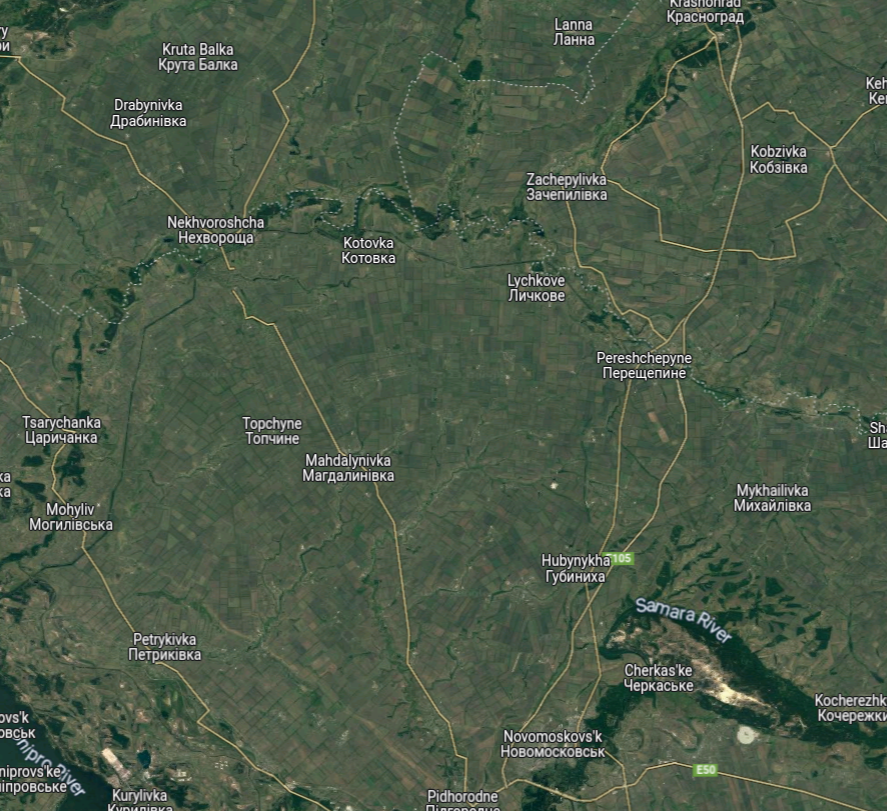

In [6]:
from IPython.display import Image

# Replace "path/to/image.png" with the actual path to your image file
Image(filename='Data/MyPhotos/GoogleMaps.png')

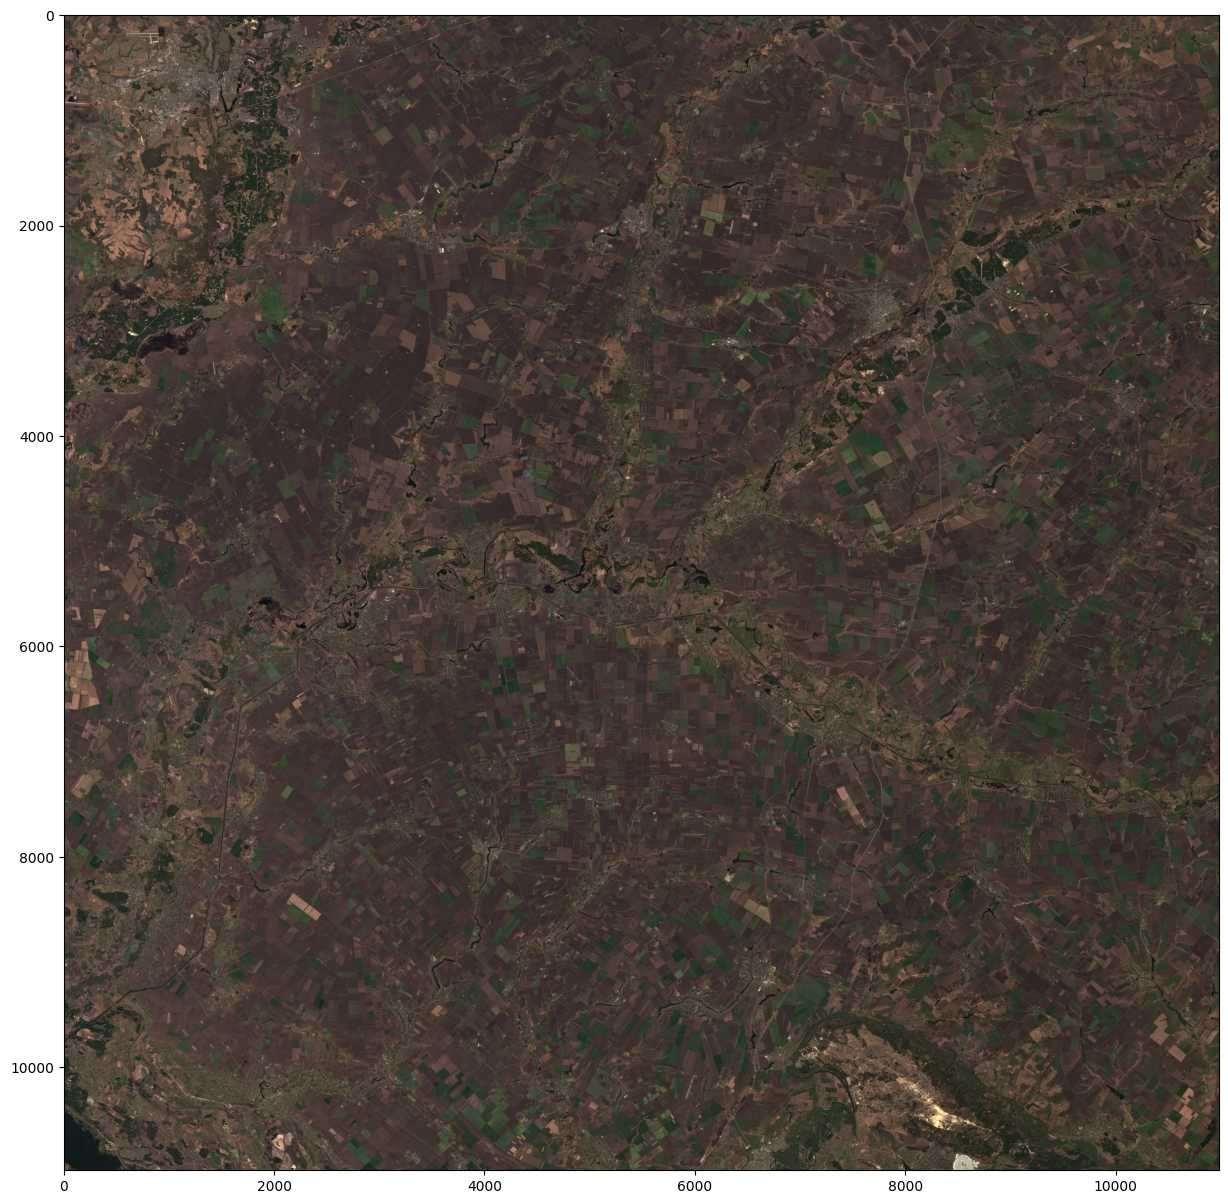

In [7]:
plt.figure(figsize=(15,15))
plt.imshow(raster_img)

The next step is to open our .shp mask

In [8]:
train_df = gpd.read_file("Data/masks/Masks_T36UXV_20190427.shp")
print(len(train_df))
train_df.head(5)

936


id  Data  Code       Descriptio Comments                   Image  \
0 NaN   NaN   2.0   branch of tree      NaN  T36UXV_20190427T083601   
1 NaN   NaN   1.0  color+ feathers      NaN  T36UXV_20190427T083601   
2 NaN   NaN   2.0   brahch of tree      NaN  T36UXV_20190427T083601   
3 NaN   NaN   1.0  color+ feathers      NaN  T36UXV_20190427T083601   
4 NaN   NaN   1.0  color+ feathers      NaN  T36UXV_20190427T083601   

                                            geometry  
0  POLYGON ((35.62916 49.60293, 35.63015 49.60163...  
1  POLYGON ((35.65070 49.60254, 35.65248 49.60301...  
2  POLYGON ((35.63023 49.60826, 35.62960 49.60920...  
3  POLYGON ((35.62033 49.60905, 35.62064 49.60968...  
4  POLYGON ((35.60455 49.61078, 35.60597 49.61228...

The desert in Iran(Kharkiv, Ukraine) coordinates I have said about this above

In [9]:
train_df['geometry'][0].exterior.coords.xy

(array('d', [35.62916346617293, 35.63014960535702, 35.631175190108465, 35.631214635675825, 35.630031268654925, 35.62888734720139, 35.62813788142149, 35.62774342574785, 35.62813788142149, 35.62916346617293]),
 array('d', [49.602931546762534, 49.60162984303954, 49.60080148612491, 49.59981534694083, 49.6001703570471, 49.60111705066382, 49.60214263541526, 49.60289210119517, 49.60312877459935, 49.602931546762534]))

The next step is to fit our mask

In [10]:
src = rasterio.open(raster_path, 'r')
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
    except:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 936 files


Rasterio failed to plot 100% of our mask.

The reason is that CRS of masks and raster image do not match

Let's try to plot our mask with EPSG 4326(tipically used in this region)

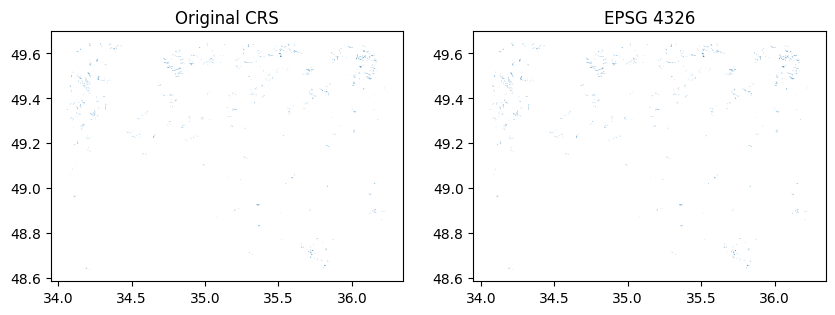

In [11]:
gdf = gpd.read_file("Data/masks/Masks_T36UXV_20190427.shp")

gdf_4326 = gdf.to_crs('EPSG:4326')


fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
gdf.plot(ax=ax[0])
ax[0].set_title('Original CRS')
gdf_4326.plot(ax=ax[1])
ax[1].set_title('EPSG 4326')
plt.show()

Let's try one more time but with epsg 4326

In [14]:
train_df = gpd.read_file("Data/masks/Masks_T36UXV_20190427.shp")

id_values = range(1, 937)

# Assign the sequence of numbers to the 'id' column
train_df['id'] = id_values
# let's remove rows without geometry
train_df = train_df[train_df.geometry.notnull()]

# assigning crs
train_df.crs = ('epsg:4326')

#transforming polygons to the raster crs
train_df = train_df.to_crs(raster_meta['crs']['init'])

In [15]:
train_df

id  Data  Code        Descriptio Comments                   Image  \
0      1   NaN   2.0    branch of tree      NaN  T36UXV_20190427T083601   
1      2   NaN   1.0   color+ feathers      NaN  T36UXV_20190427T083601   
2      3   NaN   2.0    brahch of tree      NaN  T36UXV_20190427T083601   
3      4   NaN   1.0   color+ feathers      NaN  T36UXV_20190427T083601   
4      5   NaN   1.0   color+ feathers      NaN  T36UXV_20190427T083601   
..   ...   ...   ...               ...      ...                     ...   
931  932   NaN   1.0  color+ structure      NaN  T36UXV_20190427T083601   
932  933   NaN   1.0  color+ structure      NaN  T36UXV_20190427T083601   
933  934   NaN   1.0  color+ structure      NaN  T36UXV_20190427T083601   
934  935   NaN   1.0  color+ structure      NaN  T36UXV_20190427T083601   
935  936   NaN   1.0  color+ structure      NaN  T36UXV_20190427T083601   

                                              geometry  
0    POLYGON ((689961.152 5497804.667, 690037.456 5...  
1    POLYGON ((691518.623 5497815.456, 691645.003 5...  
2    POLYGON ((690017.383 5498399.293, 689968.112 5...  
3    POLYGON ((689299.133 5498462.011, 689319.252 5...  
4    POLYGON ((688152.716 5498615.331, 688249.512 5...  
..                                                 ...  
931  POLYGON ((690012.338 5435767.601, 689998.527 5...  
932  POLYGON ((689303.051 5435318.547, 689365.361 5...  
933  POLYGON ((690499.318 5436948.995, 690529.292 5...  
934  POLYGON ((685438.102 5404906.207, 685405.307 5...  
935  POLYGON ((685260.344 5405067.394, 685271.346 5...  

[935 rows x 7 columns]

In [17]:
src = rasterio.open(raster_path, 'r', driver="JP2OpenJPEG")
outfolder = "article_t"
os.makedirs(outfolder, exist_ok=True)
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
        img_image = reshape_as_image(masked_image)
        img_path = os.path.join(outfolder, str(row['id']) + '.png')
        img_image = cv2.cvtColor(img_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(img_path, img_image)
    except Exception as e:
        #print(e)
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 435 files


### Great! Rasterio failed to mask only about 46.5%

It is easy to explain

I have prepared a little image for this

I have marked with green rectangle the area that is covered by T36UXV_20200406T083559_TCI_10m.jp2 tile and with red polygons which we have missed

In [ ]:
Image(filename='Data/MyPhotos/EPSG4326.png')

The following code was totally  inspired by 

https://medium.datadriveninvestor.com/preparing-aerial-imagery-for-crop-classification-ce05d3601c68

Thank You!

In [ ]:
# rasterize works with polygons that are in image coordinate system

def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = unary_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for field/not_filed segmentation.

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)



The next step is to plot our mask

In [ ]:
mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

# plotting the mask

plt.figure(figsize=(15,15))
plt.imshow(mask)

And let's save binary mask to train.jp2 file

In [ ]:
bin_mask_meta = src.meta.copy()
bin_mask_meta.update({'count': 1})
with rasterio.open("train.jp2", 'w', **bin_mask_meta) as dst:
    dst.write(mask * 255, 1)